This notebook will now have 

1. Q values differences for Contra - Ipsi from last trial 
2. Q values for chosen (Before choice) 
3. Q values differences for chosen - unchosen 

4. NaC + DMS GCaMP data 

In [2]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)



In [3]:
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp.csv", index_col = 0)

# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all


# df_gcamp = pd.read_csv("data/timelocked_gcamp_all.csv", index_col = 0)
# df_src = df_gcamp 
df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



In [4]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

# getting df_trials

In [ ]:
# pulling the data with sessions info and the data with gcamp together. 
data = pd.read_csv('./data/rachel_table.csv', names = ['gcamp', 'TrialStart', 'NosePokeEnter', 'NosePokeExit', 'LeverPresentation',
                                                       'IpsLeverPress', 'ConLeverPress', 'CSplus', 'CSneg', 'RewardEnter',
                                                       'RewardExit', 'MouseID', 'RecordLoc', 'Session'])

data_g = pd.read_csv('./data/dan_table.csv')

data['gcamp'] = data_g['gcamp']

data = data[(data['RecordLoc'] != 5) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)

In [ ]:
%%time 
# pull out trial by trial info 


            
data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]
    trial_starts = np.where(data_small['TrialStart'] == 1)[0]
    num_trials = len(trial_starts)
    
    # keep track of trial_num so that it updates to 0 when we are at the new recording area 
    trial_i = -1 # so for first trial, it will update to 0  
    recordloc_curr = data_small.iloc[0].RecordLoc 

    for t_i, t in enumerate(trial_starts): # t_i just checks if we are at the last trial for the mouse 
        


        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        data_trial = data_small[t:trial_end];

#         lever_press = np.where(trial_df['LeverPresentation'] == 1)[0][0]
        if sum(data_trial.IpsLeverPress.values) >  sum(data_trial.ConLeverPress.values):
            action = 'Ips'
        else:
            action = 'Con'

        if sum(data_trial.CSplus.values) >  sum(data_trial.CSneg.values):
            reward = 1
        else:
            reward = 0

        sess = data_trial.iloc[0].Session
        recordloc = data_trial.iloc[0].RecordLoc
        
        if recordloc_curr == recordloc: # still at old recording location, update as needed 
            trial_i += 1      
        else: # we are at new recording location 
            trial_i = 0
            recordloc_curr = recordloc 
            
            
        
        data_t.append([ mouse_id - 1, trial_i, action, reward, sess, recordloc]) #  t, lever_press])


  

In [ ]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 
                                             'Session', 'RecordLoc')) # 'TrialStart',
                


In [ ]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

# gcamp

In [ ]:
data_DMS = data[(data['RecordLoc'] == 1) ]
data_NAC = data[(data['RecordLoc'] == 2) ]


In [ ]:
# normalize

def normalize(x, mu, std):
    return (x - mu) / std

for data_src, save in zip([data_DMS, data_NAC], [0, 1]):

    for mouse_id in np.unique(data_src['MouseID']):
        mice_gcamp = np.copy(data_src.loc[data_src['MouseID'] == mouse_id, 'gcamp'].values)
        mice_mu = (np.mean(mice_gcamp))
        mice_std = (np.std(mice_gcamp))

        data_src.loc[data_src['MouseID'] == mouse_id, 'gcamp'] = normalize(mice_gcamp, mice_mu, mice_std)

    

In [ ]:
%%time
# pull out trial by trial info 

data_g = []
data_nac = []

for data_src, save in zip([data_DMS, data_NAC], [data_g, data_nac]):



    for mouse_id in np.unique(data['MouseID']):
        data_small = data_src[data_src['MouseID'] == mouse_id]
        trial_starts = np.where(data_small['TrialStart'] == 1)[0]
        num_trials = len(trial_starts)
        
        # for stay/leave from last trial
        last_sess = -1

        for t_i, t in enumerate(trial_starts):
            if t_i == (num_trials - 1):
                trial_end = len(data_small)
            else:
                trial_end = trial_starts[t_i + 1]

            data_trial = data_small[t:trial_end];

            # get gcamp after nose poke enter and before lever press 
            npe_i = np.where(data_trial['NosePokeEnter'] == 1)[0][0]
            lp_i = np.where(data_trial['LeverPresentation'] == 1)[0][0]


            # check choice and record time between lever and choice 
            if sum(data_trial.IpsLeverPress.values) >  sum(data_trial.ConLeverPress.values):
                action = 'Ips'
                choice_i = np.where(data_trial['IpsLeverPress'] == 1)[0][0]
            else:
                action = 'Con'
                choice_i = np.where(data_trial['ConLeverPress'] == 1)[0][0]


            # check if mice is rewarded 
            if sum(data_trial.CSplus.values) >  sum(data_trial.CSneg.values):
                reward = 1
                reward_i = np.where(data_trial['CSplus'] == 1)[0][0]
                reward_end_i =  np.where(data_trial['RewardExit'] == 1)[0][0]
            else:
                reward = 0
                reward_i = np.where(data_trial['CSneg'] == 1)[0][0]
            
            
        
            # get timelocked gcamp to each event             
            gcamp_np = data_small['gcamp'].values[(t + npe_i - LEN_BEFORE): (t + npe_i + LEN_AFTER)]
            gcamp_lp = data_small['gcamp'].values[(t + lp_i - LEN_BEFORE): (t + lp_i + LEN_AFTER)]
            gcamp_choice = data_small['gcamp'].values[(t + choice_i - LEN_BEFORE): (t + choice_i + LEN_AFTER)]
            gcamp_reward = data_small['gcamp'].values[(t + reward_i - LEN_BEFORE): (t + reward_i + LEN_AFTER)]
        
                    
            sess = data_trial.iloc[0].Session
            recordloc = data_trial.iloc[0].RecordLoc
            # check if mice stayed/left from previous choice
              
            if last_sess != sess: # start of new session
                ref = np.nan
                last_sess = sess
            else:
                if last_action == action:
                    ref = 'stay'
                else:
                    ref = 'leave'



            save.append([ mouse_id - 1, t_i, action, reward, ref, 
                           gcamp_np,
                           gcamp_lp, 
                           gcamp_choice, 
                            gcamp_reward, sess, recordloc]) #  lever_press])

            # save last action for determining if mice stays/leaves
            last_action = action



In [ ]:
df_DMS = pd.DataFrame(data_g, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 
                                             'g_np', 
                                              'g_lp', 
                                             'g_choice', 
                                             'g_reward', 'Session', 'RecordLoc')) 



df_NAC = pd.DataFrame(data_nac, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 
                                             'g_np', 
                                              'g_lp', 
                                             'g_choice', 
                                             'g_reward', 'Session', 'RecordLoc')) 

df_DMS['Reward_last'] = df_DMS['Reward'].groupby([df_DMS['Session'], df_DMS['MouseID']]).shift(1)


df_NAC['Reward_last'] = df_NAC['Reward'].groupby([df_DMS['Session'], df_DMS['MouseID']]).shift(1)

df_gcamp = pd.concat([df_DMS, df_NAC], ignore_index = True)

df_gcamp = df_gcamp.replace({'RecordLoc': {1: 'DMS', 2: 'NaC'}})






In [ ]:
%%time
# df_gcamp.to_csv(os.path.join('data/', 'timelocked_gcamp_all.csv'))


In [ ]:
df_src = df_gcamp[df_gcamp['RecordLoc'] == 'NaC']

figure = plt.figure(figsize = (10, 5))
for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


    for r, r_st in zip([0, 1], [':', '-']):
        _g_reward = np.vstack(df_src[(df_src['Reward_last'] == r) & (df_src['Stay/Leave'] == 'stay') & (df_src['Action'] == ch)]['g_lp'])
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(_g_reward, axis = 0)
        error = np.std(y, axis = 0) / np.sqrt(NS)

        plt.plot(x, y, 'k', linestyle = r_st)
        plt.ylim([-0.5, 2.0])

        plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
        plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
plt.title('gCamp (timelocked to lever presentation) for all Leave Trials \n Rewarded/Not-Rewarded last trial')

plt.legend()


In [ ]:
figure = plt.figure(figsize = (10, 5))
for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


    for r, r_st in zip([0, 1], [':', '-']):
        _g_reward = np.vstack(df_DMS[(df_DMS['Reward_last'] == r) & (df_DMS['Stay/Leave'] == 'stay') & (df_DMS['Action'] == ch)]['g_choice'])
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(_g_reward, axis = 0)
        error = np.std(y, axis = 0) / np.sqrt(NS)

        plt.plot(x, y, 'k', linestyle = r_st)
        plt.ylim([-0.5, 2.0])

        plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
        plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
plt.title('gCamp (timelocked to lever press) for all Stay Trials \n Rewarded/Not-Rewarded last trial')

plt.legend()


## use previous Q value difference to correlate with gcamp

In [ ]:
import pickle
extract = pickle.load( open( "data/StanFit_int_pc.pickle", "rb" ) )
summary = pd.DataFrame.from_csv("data/summary_int_pc.csv")

# fncs for pulling out the actual alpha 

def inv_logit(arr):
    '''Elementwise inverse logit (logistic) function.'''
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal. 
    For details, see Bowling et al. (2009). "A logistic approximation 
    to the cumulative normal distribution."'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

# ## Save summary file.
# summary = fit2.summary()
# summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
# summary.to_csv(os.path.join('data/', 'summary_int_pc.csv'))

# # Save contents of StanFit.
# extract = fit2.extract()
# for k, v in standata.items(): extract[k] = v
# with open(os.path.join('data/' 'StanFit_int_pc.pickle'), 'wb') as fn: cPickle.dump(extract, fn)




In [ ]:
%%time 

# to do: get Q_chosen, Q_unchosen, Q_ipsi, Q_contra, Q_dir_diff, Q_ch_diff 


# get the predictions: 
N_samples = np.shape(extract['betas'])[0]


Q_i = np.zeros((N_samples, NS, (NT + 1)), float)
Q_c = np.zeros((N_samples, NS, (NT + 1)), float)
delta = np.zeros((N_samples, NS, NT), float)
Q_choice_saved = np.zeros((N_samples, NS, (NT + 1)), float)
Q_other_saved = np.zeros((N_samples, NS, (NT + 1)), float)


for s in np.arange(NS):

    for t in np.arange(extract['NT_all'][s]):

        r_i = extract['r'][s, t]
        c_i = extract['c'][s, t]

        if c_i == 0: # contra choice
            Q_choice = Q_c; 
            Q_other = Q_i; 
        elif c_i == 1: # ipsa choice
            Q_choice = Q_i; 
            Q_other = Q_c; 
            
        delta[:, s, t] = r_i - Q_choice[:, s, t] 
        
        Q_choice_saved[:, s, t] = np.copy(Q_choice[:, s, t])
        Q_other_saved[:, s, t] = np.copy(Q_other[:, s, t])
        # Q of the choice is updated, the other one is not. 
        Q_choice[:, s, t + 1] = Q_choice[:, s, t] + phi_approx(extract['alphas'][:,s]) * delta[:, s, t]
        Q_other[:, s, t + 1] = Q_other[: ,s, t]
        
        





In [ ]:

_Q_i = np.mean(Q_i, 0)
_Q_c = np.mean(Q_c, 0)
_Q_dir_diff = np.mean(Q_c - Q_i, 0)


_Q_chosen = np.mean(Q_choice_saved, 0)
_Q_ch_diff = np.mean(Q_choice_saved - Q_other_saved, 0)



In [ ]:
# putting the Q values and df_trials together 

# put Q value from matrix --> vector (with the extra empty trials taken out)

for name in ['_Q_c', '_Q_dir_diff', '_Q_chosen', '_Q_ch_diff']:  # really awful awkward eval 
    vec = np.zeros(sum(NT_all))
    mat = eval(name)
    for s in np.arange(NS):
        if s < 11:
            vec[sum(NT_all[:s]) : sum(NT_all[:(s + 1)])] = (mat[s, :NT_all[s]])

        else: 
            vec[sum(NT_all[:s]) : ] = (mat[s, :NT_all[s]])

    df_trials[name[1:]] = vec
    
    
# shift one up for the Q_c and Q_dir_diff

df_trials['Q_c'] = df_trials['Q_c'].groupby([df_trials['MouseID'], df_trials['RecordLoc'], df_trials['Session']]).shift(1)
df_trials['Q_dir_diff'] = df_trials['Q_dir_diff'].groupby([df_trials['MouseID'], df_trials['RecordLoc'], df_trials['Session']]).shift(1)



In [ ]:
%%time
# df_trials.to_csv(os.path.join('data/', 'int_pc_qvals.csv'))


# putting the Q values and gcamp together

In [ ]:
# merging them together 
df_trials_small = df_trials[df_trials['RecordLoc'] < 3].replace({'RecordLoc': {1: 'DMS', 2: 'NaC'}})

df_corr = pd.merge(df_gcamp, df_trials_small, on = ['MouseID', 'RecordLoc', 'Trial', 'Action', 'Reward', 'Session']  
                   ,how = 'inner', validate='1:1') # , indicator = True)

df_corr.to_csv(os.path.join('data/', 'int_pc_qvals_gcamp.csv'))


# plots

In [19]:
# df_corr = pd.DataFrame.from_csv("data/int_pc_qvals_gcamp.csv")
df_corr_all = df_corr_all.dropna(subset=['Q_dir_diff'])

df_corr = df_corr_all # df_corr_all[df_corr_all['RecordLoc'] == 'DMS']


Text(0,0.5,'Max GCaMP \n(timelocked to various times)')

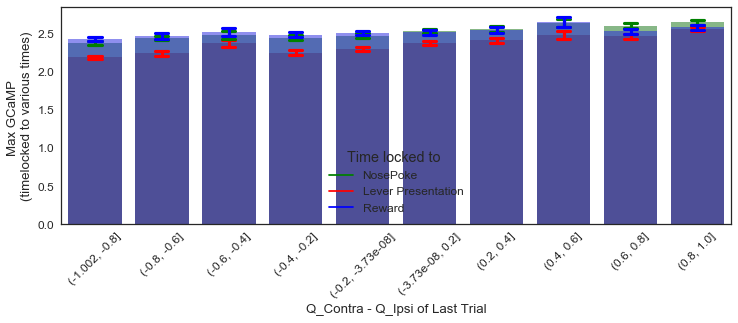

In [20]:
fig = plt.figure(figsize = (12, 4))
df_corr['bQ_dir_diff'] = pd.cut(df_corr['Q_dir_diff'], 10)
df_corr['max_np'] = [max(x) for x in df_corr['g_np']]
df_corr['max_lp'] = [max(x) for x in df_corr['g_lp']]
df_corr['max_r'] = [max(x) for x in df_corr['g_reward']]



plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')
plt.legend(title = 'Time locked to ')
sns.barplot(data=df_corr, x = 'bQ_dir_diff', y = 'max_np', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_dir_diff', y = 'max_lp', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_dir_diff', y = 'max_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')

plt.xticks(rotation=45)
plt.xlabel('Q_Contra - Q_Ipsi of Last Trial')
plt.ylabel('Max GCaMP \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

Text(0,0.5,'Max GCaMP \n(timelocked to various times)')

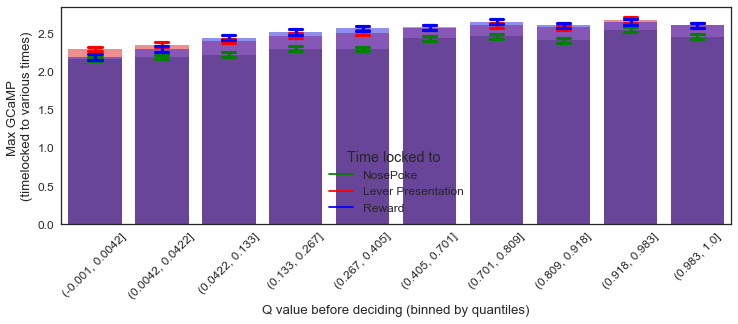

In [21]:
fig = plt.figure(figsize = (12, 4))
df_corr['bQ_chosen'] = pd.qcut(df_corr['Q_chosen'], 10)


plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')
plt.legend(title = 'Time locked to ')

sns.barplot(data=df_corr, x = 'bQ_chosen', y = 'max_np', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_chosen', y = 'max_lp', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_chosen', y = 'max_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')
plt.xticks(rotation=45)
plt.xlabel('Q value before deciding (binned by quantiles)')
plt.ylabel('Max GCaMP \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

Text(0,0.5,'Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')

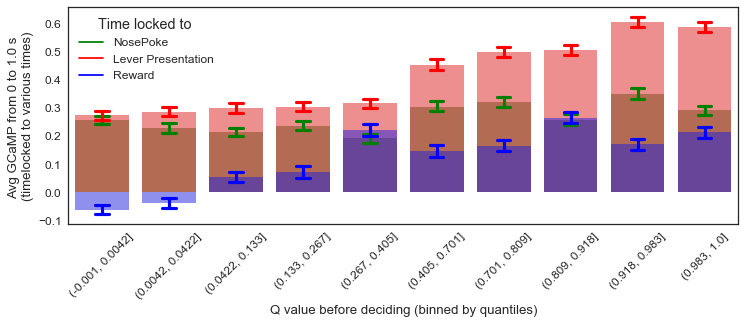

In [22]:
fig = plt.figure(figsize = (12, 4))
df_corr['avg_np'] = [np.mean(x[15:30], 0) for x in df_corr['g_np']]
df_corr['avg_lp'] = [np.mean(x[15:30], 0) for x in df_corr['g_lp']]
df_corr['avg_r'] = [np.mean(x[15:30], 0) for x in df_corr['g_reward']]

plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')
plt.legend(title = 'Time locked to ')

sns.barplot(data=df_corr, x = 'bQ_chosen', y = 'avg_np', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_chosen', y = 'avg_lp', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_chosen', y = 'avg_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')
plt.xticks(rotation=45)
plt.xlabel('Q value before deciding (binned by quantiles)')
plt.ylabel('Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

Text(0,0.5,'Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')

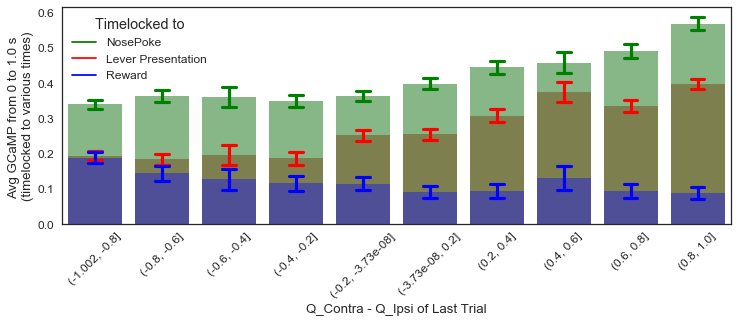

In [23]:
fig = plt.figure(figsize = (12, 4))



plt.plot([], color = 'g', label = 'NosePoke')
plt.plot([], color = 'r', label = 'Lever Presentation')
plt.plot([], color = 'b', label = 'Reward')

plt.legend(title = 'Timelocked to')

sns.barplot(data=df_corr, x = 'bQ_dir_diff', y = 'avg_np', ci = 68,  color = 'r', alpha = 0.5,  capsize = 0.2, errcolor = 'r')
sns.barplot(data=df_corr, x = 'bQ_dir_diff', y = 'avg_lp', ci = 68,  color = 'g', alpha = 0.5, capsize = 0.2, errcolor = 'g')
sns.barplot(data=df_corr, x = 'bQ_dir_diff', y = 'avg_r', ci = 68, color = 'b', alpha = 0.5, capsize = 0.2, errcolor = 'b')
plt.xticks(rotation=45)
plt.xlabel('Q_Contra - Q_Ipsi of Last Trial')
plt.ylabel('Avg GCaMP from 0 to 1.0 s \n(timelocked to various times)')
# [df_DMS['Stay/Leave'] == 'stay']

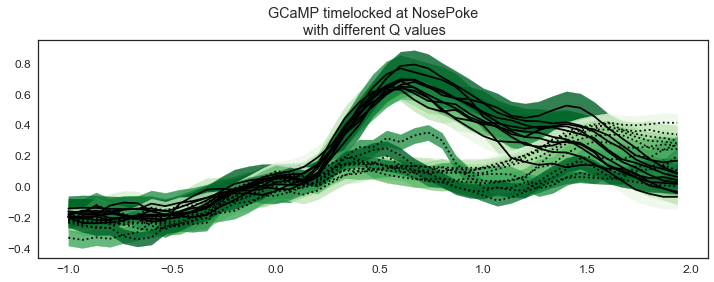

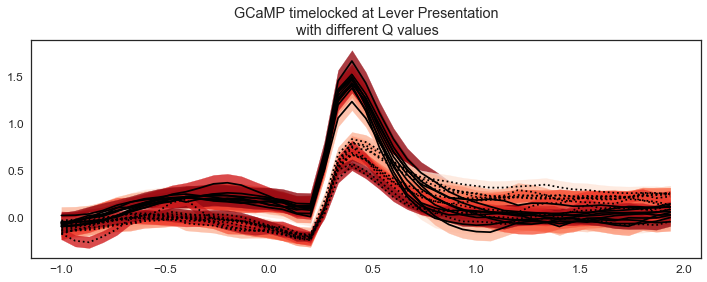

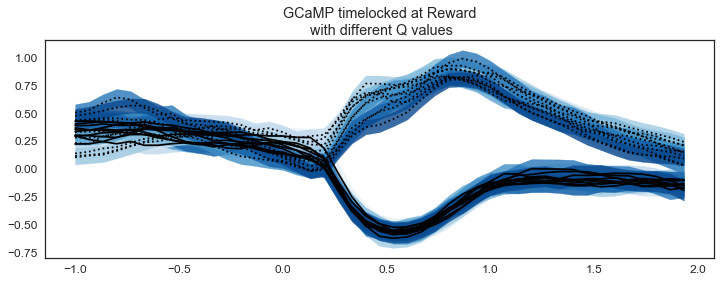

In [24]:
# if True:

for timelocked, tl_name, palette in zip(['g_np', 'g_lp', 'g_reward'], ['NosePoke', 'Lever Presentation', 'Reward'], ['Greens', 'Reds','Blues']):
    figure = plt.figure(figsize=(12, 4))

    if tl_name == 'Reward':
        categories = [0, 1]
        column = 'Reward'
        
    else:
        categories = ['Con', 'Ips']
        column = 'Action'
    for subcat, line_type in zip(categories, ['-', ':']):
        df_src = df_corr[df_corr[column] == subcat]


        qlims = np.unique(df_src['bQ_dir_diff'].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src['Q_dir_diff'] > q_i.left) & (df_src['Q_dir_diff'] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = line_type)

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n with different Q values')
#     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



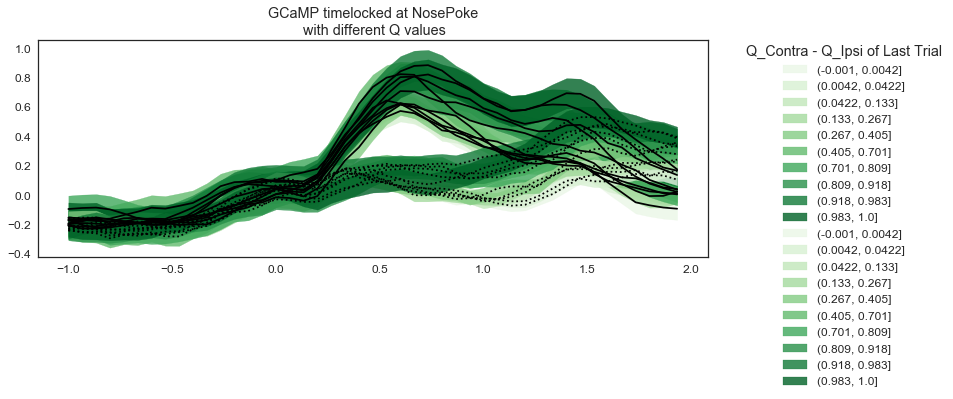

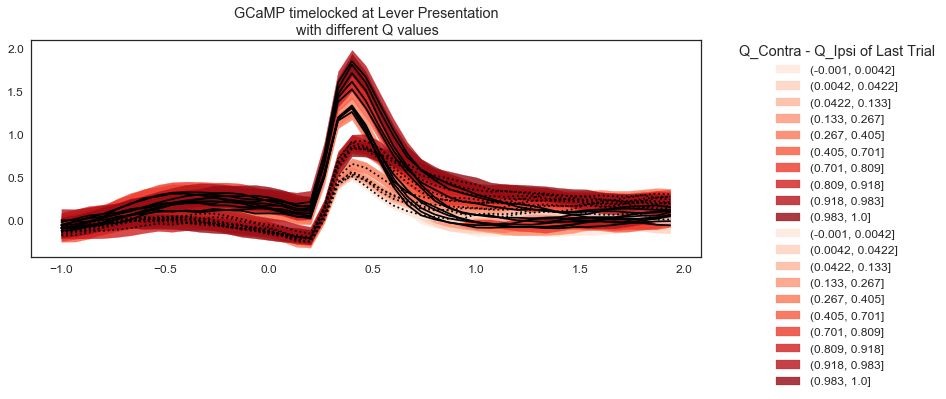

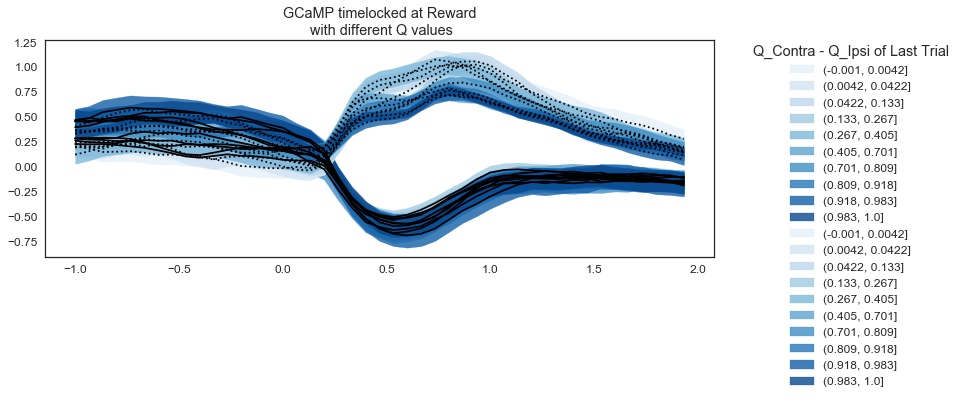

In [25]:
# if True:

for timelocked, tl_name, palette in zip(['g_np', 'g_lp', 'g_reward'], ['NosePoke', 'Lever Presentation', 'Reward'], ['Greens', 'Reds','Blues']):
    figure = plt.figure(figsize=(12, 4))

    if tl_name == 'Reward':
        categories = [0, 1]
        column = 'Reward'
        
    else:
        categories = ['Con', 'Ips']
        column = 'Action'
    for subcat, line_type in zip(categories, ['-', ':']):
        df_src = df_corr[df_corr[column] == subcat]


        qlims = np.unique(df_src['bQ_chosen'].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src['Q_chosen'] > q_i.left) & (df_src['Q_chosen'] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = line_type)

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n with different Q values')
    plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [26]:
df_corr.head()

,MouseID,Trial,Action,Reward,Stay/Leave,g_np,g_lp,g_choice,g_reward,Session,...,Q_chosen,Q_ch_diff,bQ_dir_diff,max_np,max_lp,max_r,bQ_chosen,avg_np,avg_lp,avg_r
1,0,1,Con,0,stay,"[0.24935317, 0.88644946, 0.54111839, 0.1951249...","[0.86043618, 0.90956294, 0.83174852, 0.5371606...","[0.60694142, 0.28990002, 0.27929295, 0.2699185...","[0.28990002, 0.27929295, 0.26991853, 0.1667599...",1.0,...,0.630859,0.630859,"(-3.73e-08, 0.2]",2.907416,2.907416,1.961397,"(0.405, 0.701]",0.085869,0.590227,-0.155152
2,0,2,Con,0,stay,"[0.43089861, 0.11584545, 0.1952726, 0.34841672...","[0.40455089, 0.38669313, 0.27724199, 0.7762112...","[1.16059757, 0.126492, -0.48633759, -0.8527932...","[-0.48633759, -0.8527932, -1.09625441, -0.6939...",1.0,...,0.231278,0.231278,"(0.6, 0.8]",1.654285,1.654285,0.982252,"(0.133, 0.267]",0.229038,-0.121461,-0.498222
3,0,3,Con,0,stay,"[0.24097197, 0.61742871, 0.39211373, 0.265267,...","[0.41705304, 0.55005947, 0.70424546, 0.5874756...","[1.14882825, 1.87424883, 1.13878115, 0.5138715...","[0.51387152, -0.33462785, -0.52250574, -0.7790...",1.0,...,0.085800,0.085800,"(0.2, 0.4]",1.874249,1.874249,1.130161,"(0.0422, 0.133]",0.109538,0.060571,-0.696753
4,0,4,Con,0,stay,"[0.60463664, 0.37730082, 0.54562974, 0.4443448...","[-0.32351542, -0.21644796, -0.12516897, -0.247...","[0.887543, 0.37905758, -0.14987551, -0.6413382...","[-0.11321078, 0.03484009, 0.47696836, 0.111937...",1.0,...,0.032192,0.032192,"(-3.73e-08, 0.2]",0.887543,0.887543,1.615885,"(0.0042, 0.0422]",-0.311955,-0.362587,0.004965
5,0,5,Con,0,stay,"[1.29213797, 1.03885472, -0.07290037, -0.44686...","[-1.08379162, -0.95252338, -0.93781172, -0.918...","[-0.78505754, -0.5551198, -0.52874187, -0.9117...","[1.06630288, 0.58343953, -0.15986071, -0.59082...",1.0,...,0.012210,0.012210,"(-3.73e-08, 0.2]",1.564308,1.564308,1.066303,"(0.0042, 0.0422]",-0.325620,0.082603,-0.430882


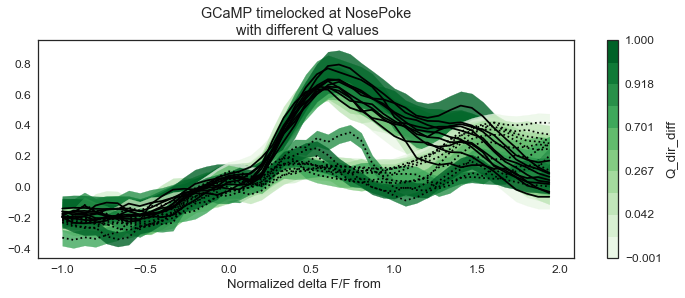

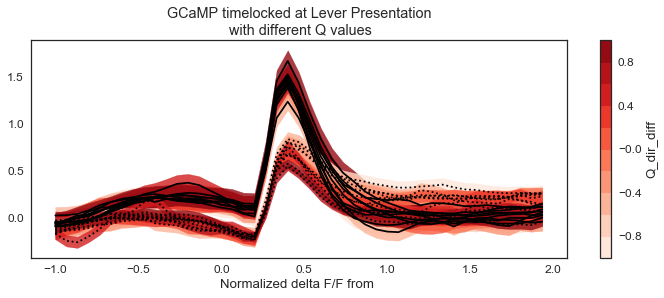

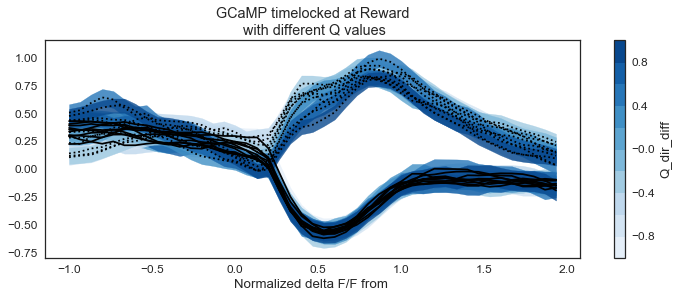

In [27]:
# if True:
df_corr['bQ_ch_diff'] = pd.cut(df_corr['Q_ch_diff'], 10)

Q_to_plot = 'Q_dir_diff'
src = 'DMS'

for timelocked, tl_name, palette in zip(['g_np', 'g_lp', 'g_reward'], ['NosePoke', 'Lever Presentation', 'Reward'], ['Greens', 'Reds','Blues']):
    figure = plt.figure(figsize=(12, 4))

    if tl_name == 'Reward':
        categories = [0, 1]
        column = 'Reward'
    else:
        categories = ['Con', 'Ips']
        column = 'Action'
        
        
    # legend plotting 1. colorbar for the q values 2. the 
    cmap = ListedColormap(sns.color_palette(palette, len(qlims)).as_hex())
    bounds = [x.left for x in qlims] + [qlims[-1].right]
    norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
    dummy_plot = plt.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
    plt.clf()
    cbar = plt.colorbar(dummy_plot)
    cbar.set_label(Q_to_plot)

    for subcat, line_type in zip(categories, ['-', ':']):
        df_src = df_corr[df_corr[column] == subcat]


        qlims = np.unique(df_src['b' + Q_to_plot].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src[Q_to_plot] > q_i.left) & (df_src[Q_to_plot] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = line_type)

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n with different Q values')
            plt.xlabel('Normalized delta F/F from ')
            
            

#     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [ ]:
import .ListedColormap as  from 